# REACTIVA Perú 2022 — Análisis con Lasso (estructura Jupyter)

**Autores:** Luis Lucero, Alexis del Castillo, May Attilano  
**Fecha de creación:** 2025-09-03 03:56

Este cuaderno replica en **Python/Jupyter** el flujo del script en R (importación, EDA y modelo L1 *Lasso* con regresión logística), reutilizando la misma lógica y pasos.



## 0) Metadatos y entorno
- Lenguaje: Python 3
- Librerías: `pandas`, `numpy`, `matplotlib`, `scikit-learn`
- Notas:
  - Los gráficos usan **matplotlib** (sin seaborn) y **una figura por gráfico**.
  - No se especifican colores manualmente.
  - Los nombres de columnas se normalizan para asemejar los usados en el script R.


In [2]:

# === Imports base ===
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score,
    roc_curve, classification_report
)

# Mostrar todas las columnas en outputs tabulares
pd.set_option('display.max_columns', None)



## 1) Importación y preparación de datos

Actualiza la lista `archivos` para apuntar a tus Excel. El cuaderno concatena todas las primeras hojas (por defecto).


In [4]:

# === Carga de datos desde Excel ===
# Puedes colocar aquí tus archivos .xlsx (por ejemplo en /mnt/data o en el mismo directorio del notebook)
archivos = [
    "reactiva_peru_2022.xlsx",  # ajusta el nombre/ruta si es necesario
]

# Lectura y concatenación
dfs = []
for f in archivos:
    if not os.path.exists(f):
        print(f"ADVERTENCIA: No se encontró el archivo: {f}. Colócalo en el mismo directorio del cuaderno o indica la ruta completa.")
    else:
        dfs.append(pd.read_excel(f))

if len(dfs) == 0:
    # Creamos un DataFrame vacío con las columnas esperadas como plantilla,
    # así el resto del cuaderno es visible y editable aunque no tengas el archivo a mano aún.
    df = pd.DataFrame(columns=[
        "ORDEN","RAZÓN SOCIAL","RUC/DNI","SECTOR ECONÓMICO",
        "NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO","DEPARTAMENTO",
        "SALDO INSOLUTO (S/)","COBERTURA DEL SALDO INSOLUTO(S/)","REPRO"
    ])
    print("Plantilla creada porque no se pudo cargar ningún archivo.")
else:
    df = pd.concat(dfs, ignore_index=True)

print("Dimensiones:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)


Dimensiones: (446784, 9)

Tipos de datos:
ORDEN                                        int64
RAZÓN SOCIAL                                object
RUC/DNI                                      int64
SECTOR ECONÓMICO                            object
NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO     object
DEPARTAMENTO                                object
SALDO INSOLUTO (S/)                        float64
COBERTURA DEL SALDO INSOLUTO(S/)           float64
REPRO                                       object
dtype: object



### Normalización de nombres de columnas

Equivalencias para asemejar el script en R:
- `RUC/DNI` → `RUC_O_DNI`
- `RAZÓN SOCIAL` → `RAZON_SOCIAL`
- `SECTOR ECONÓMICO` → `SECTOR_ECONOMICO`
- `NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO` → `ENTIDAD_OTORGANTE_CREDITO`
- `SALDO INSOLUTO (S/)` → `SALDO_INSOLUTO`
- `COBERTURA DEL SALDO INSOLUTO(S/)` → `COBERTURA_SALDO_INSOLUTO`


In [5]:

# === Renombrar columnas a estilo R ===
col_map = {
    "RUC/DNI": "RUC_O_DNI",
    "RAZÓN SOCIAL": "RAZON_SOCIAL",
    "SECTOR ECONÓMICO": "SECTOR_ECONOMICO",
    "NOMBRE DE ENTIDAD OTORGANTE DEL CRÉDITO": "ENTIDAD_OTORGANTE_CREDITO",
    "SALDO INSOLUTO (S/)": "SALDO_INSOLUTO",
    "COBERTURA DEL SALDO INSOLUTO(S/)": "COBERTURA_SALDO_INSOLUTO"
}
df = df.rename(columns=col_map)

# Reordenar columnas si existen todas
ordered_cols = [
    "ORDEN", "RAZON_SOCIAL", "RUC_O_DNI", "SECTOR_ECONOMICO",
    "ENTIDAD_OTORGANTE_CREDITO", "DEPARTAMENTO",
    "SALDO_INSOLUTO", "COBERTURA_SALDO_INSOLUTO", "REPRO"
]
df = df[[c for c in ordered_cols if c in df.columns] + [c for c in df.columns if c not in ordered_cols]]
df.head()


,ORDEN,RAZON_SOCIAL,RUC_O_DNI,SECTOR_ECONOMICO,ENTIDAD_OTORGANTE_CREDITO,DEPARTAMENTO,SALDO_INSOLUTO,COBERTURA_SALDO_INSOLUTO,REPRO
0,1,_x001A_USTA SAGRADA SAC,20553879150,HOTELES Y RESTAURANTES,BANCO BBVA PERU,LIMA,188862.88,179419.7360,NO
1,2,2L SOLUCIONES S.A.C.,20524693250,"ACTIV. INMOBILIARIAS, EMPRESARIALES ALQ.",CRÉDITO,LIMA,124896.00,118651.2000,SI
2,3,3P INVERSIONES S.A.C.,20551286348,COMERCIO,CRÉDITO,LIMA,75295.93,71531.1335,NO
3,4,A & G MISTI CONSTRUCTORESS.A.C,20542311488,MINERIA,CRÉDITO,SAN MARTIN,73613.32,69932.6540,NO
4,5,A Y N CALZADOS S.A.C.,20601959217,INDUSTRIA MANUFACTURERA,CRÉDITO,LIMA,71486.63,67912.2985,NO



### Conversión de tipos y chequeos básicos
- Convertimos categóricas a `category` (similar a *factor* en R).
- Estandarizamos la variable objetivo `REPRO` a binaria: `1` si "SI", `0` si "NO".


In [6]:

# === Conversión de tipos ===
categoricas = ["RAZON_SOCIAL","RUC_O_DNI","SECTOR_ECONOMICO",
               "ENTIDAD_OTORGANTE_CREDITO","DEPARTAMENTO"]
for c in categoricas:
    if c in df.columns:
        df[c] = df[c].astype('category')

# Normalizamos REPRO
if "REPRO" in df.columns:
    # Pasamos a str y limpiamos espacios
    df["REPRO"] = df["REPRO"].astype(str).str.strip().str.upper()
    # Permitimos valores 'SI'/'NO' o 1/0 ya existentes
    df["REPRO_BIN"] = df["REPRO"].map({"SI":1, "NO":0})
    # Si hay NaN (por otros valores), intentar convertir numéricamente
    mask_nan = df["REPRO_BIN"].isna()
    if mask_nan.any():
        df.loc[mask_nan, "REPRO_BIN"] = pd.to_numeric(df.loc[mask_nan, "REPRO"], errors="coerce")
    df["REPRO_BIN"] = df["REPRO_BIN"].fillna(0).astype(int)

print("Distribución de REPRO_BIN:")
print(df["REPRO_BIN"].value_counts(dropna=False))

print("\nResumen columnas:")
print(df.describe(include='all'))


Distribución de REPRO_BIN:
REPRO_BIN
0    312109
1    134675
Name: count, dtype: int64

Resumen columnas:
                ORDEN     RAZON_SOCIAL  RUC_O_DNI SECTOR_ECONOMICO  \
count   446784.000000           446784   446784.0           446784   
unique            NaN           446345   446784.0               14   
top               NaN  DEL PILAR MARIA       60.0         COMERCIO   
freq              NaN                7        1.0           212073   
mean    223392.500000              NaN        NaN              NaN   
std     128975.575671              NaN        NaN              NaN   
min          1.000000              NaN        NaN              NaN   
25%     111696.750000              NaN        NaN              NaN   
50%     223392.500000              NaN        NaN              NaN   
75%     335088.250000              NaN        NaN              NaN   
max     446784.000000              NaN        NaN              NaN   

       ENTIDAD_OTORGANTE_CREDITO DEPARTAMENTO  SALDO_


### Correlación de Spearman (numéricas)
Replicamos el cálculo de correlación entre `SALDO_INSOLUTO` y `COBERTURA_SALDO_INSOLUTO`.


In [7]:

# === Correlación de Spearman ===
if set(["SALDO_INSOLUTO","COBERTURA_SALDO_INSOLUTO"]).issubset(df.columns):
    sub = df[["SALDO_INSOLUTO","COBERTURA_SALDO_INSOLUTO"]].dropna()
    if len(sub) > 0:
        rho = sub["SALDO_INSOLUTO"].corr(sub["COBERTURA_SALDO_INSOLUTO"], method='spearman')
        print("Spearman rho:", rho)
    else:
        print("No hay datos suficientes para correlación.")
else:
    print("Faltan columnas numéricas requeridas para la correlación.")


Spearman rho: 0.9999983690838466



## 2) Análisis descriptivo (EDA)
Gráficos con `matplotlib`:
- Porcentaje REPRO (gráfico circular)
- Frecuencia por **DEPARTAMENTO** (barras)
- Porcentaje por **DEPARTAMENTO** (barras)
- Frecuencia por **SECTOR_ECONOMICO** (barras)
- Porcentaje por **SECTOR_ECONOMICO** (barras)
- Frecuencia por **SECTOR_ECONOMICO** desagregada por **REPRO** (barras agrupadas)


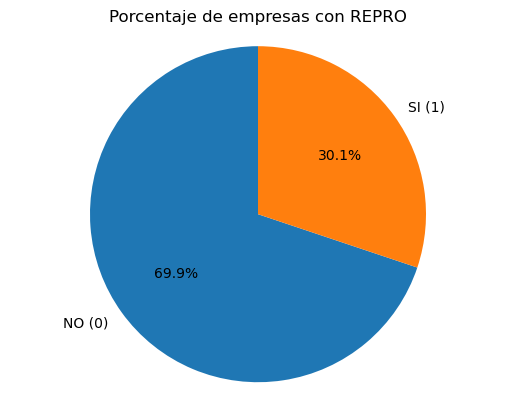

In [8]:

# === Pie: porcentaje de REPRO ===
if "REPRO_BIN" in df.columns:
    counts = df["REPRO_BIN"].value_counts().sort_index()
    labels = ["NO (0)", "SI (1)"] if set(counts.index) == {0,1} else counts.index.astype(str)
    plt.figure()
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title("Porcentaje de empresas con REPRO")
    plt.axis('equal')
    plt.show()
else:
    print("No existe REPRO_BIN para graficar.")


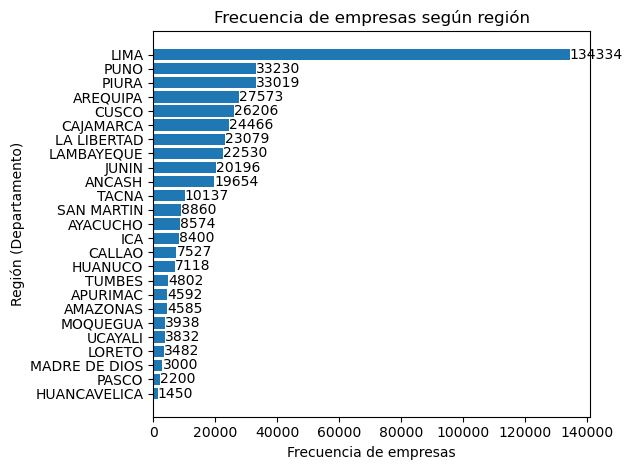

In [9]:

# === Barras: frecuencia por DEPARTAMENTO ===
if "DEPARTAMENTO" in df.columns:
    freq_dept = df["DEPARTAMENTO"].value_counts().sort_values(ascending=True)
    plt.figure()
    plt.barh(freq_dept.index.astype(str), freq_dept.values)
    plt.xlabel("Frecuencia de empresas")
    plt.ylabel("Región (Departamento)")
    plt.title("Frecuencia de empresas según región")
    # Etiquetas de cantidad al final de cada barra
    for i, v in enumerate(freq_dept.values):
        plt.text(v, i, str(int(v)), va='center', ha='left')
    plt.tight_layout()
    plt.show()
else:
    print("No existe la columna DEPARTAMENTO.")


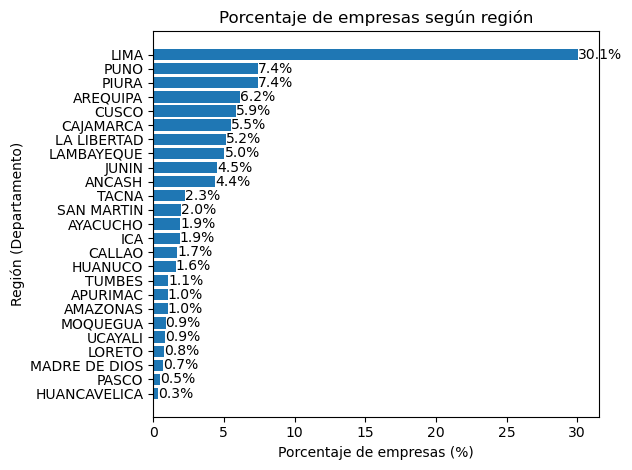

In [10]:

# === Barras: porcentaje por DEPARTAMENTO ===
if "DEPARTAMENTO" in df.columns and len(df) > 0:
    freq_dept = df["DEPARTAMENTO"].value_counts(normalize=True).sort_values(ascending=True) * 100.0
    plt.figure()
    plt.barh(freq_dept.index.astype(str), freq_dept.values)
    plt.xlabel("Porcentaje de empresas (%)")
    plt.ylabel("Región (Departamento)")
    plt.title("Porcentaje de empresas según región")
    # Etiquetas de porcentaje
    for i, v in enumerate(freq_dept.values):
        plt.text(v, i, f"{v:.1f}%", va='center', ha='left')
    plt.tight_layout()
    plt.show()
else:
    print("No existen datos suficientes para el gráfico por DEPARTAMENTO.")


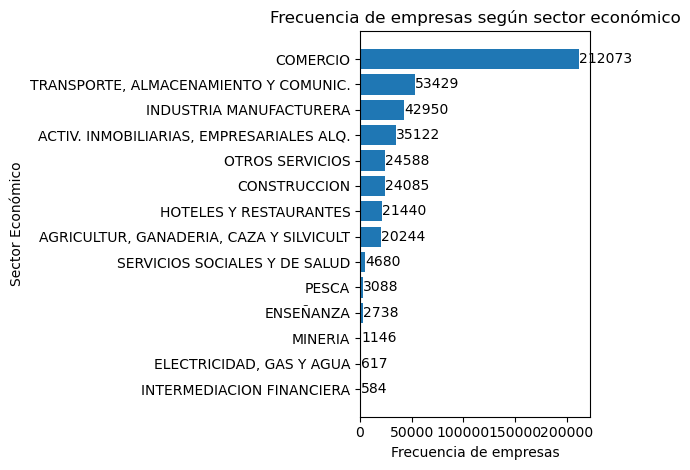

In [11]:

# === Barras: frecuencia por SECTOR_ECONOMICO ===
if "SECTOR_ECONOMICO" in df.columns:
    freq_sec = df["SECTOR_ECONOMICO"].value_counts().sort_values(ascending=True)
    plt.figure()
    plt.barh(freq_sec.index.astype(str), freq_sec.values)
    plt.xlabel("Frecuencia de empresas")
    plt.ylabel("Sector Económico")
    plt.title("Frecuencia de empresas según sector económico")
    for i, v in enumerate(freq_sec.values):
        plt.text(v, i, str(int(v)), va='center', ha='left')
    plt.tight_layout()
    plt.show()
else:
    print("No existe la columna SECTOR_ECONOMICO.")


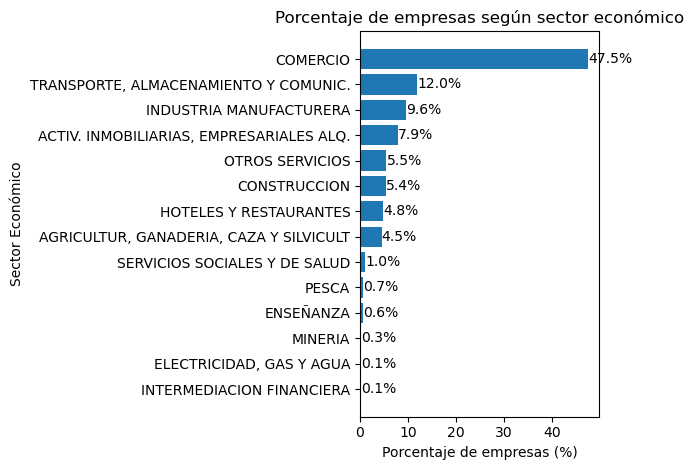

In [12]:

# === Barras: porcentaje por SECTOR_ECONOMICO ===
if "SECTOR_ECONOMICO" in df.columns and len(df) > 0:
    freq_sec = df["SECTOR_ECONOMICO"].value_counts(normalize=True).sort_values(ascending=True) * 100.0
    plt.figure()
    plt.barh(freq_sec.index.astype(str), freq_sec.values)
    plt.xlabel("Porcentaje de empresas (%)")
    plt.ylabel("Sector Económico")
    plt.title("Porcentaje de empresas según sector económico")
    for i, v in enumerate(freq_sec.values):
        plt.text(v, i, f"{v:.1f}%", va='center', ha='left')
    plt.tight_layout()
    plt.show()
else:
    print("No existen datos suficientes para el gráfico por SECTOR_ECONOMICO.")


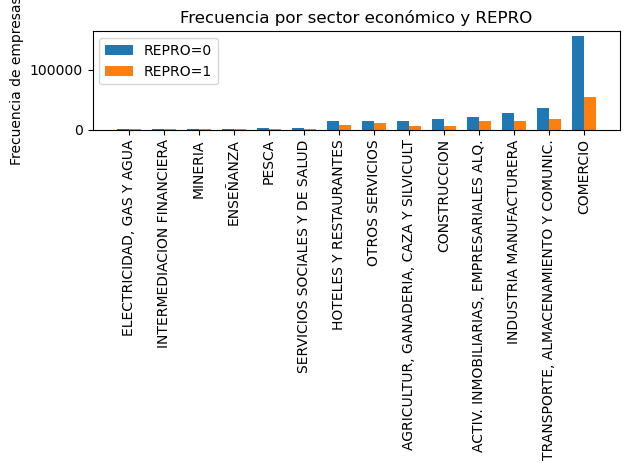

In [13]:

# === Barras agrupadas: SECTOR_ECONOMICO por REPRO ===
if set(["SECTOR_ECONOMICO","REPRO_BIN"]).issubset(df.columns):
    # Tabla de contingencia
    ctab = pd.crosstab(df["SECTOR_ECONOMICO"], df["REPRO_BIN"]).sort_values(by=[0,1] if 0 in df["REPRO_BIN"].unique() else 1, ascending=True)
    # Gráfico de barras agrupadas
    x = np.arange(len(ctab.index))
    width = 0.35
    plt.figure()
    if 0 in ctab.columns:
        plt.bar(x - width/2, ctab[0].values, width, label="REPRO=0")
    else:
        plt.bar(x - width/2, np.zeros(len(ctab.index)), width, label="REPRO=0")
    if 1 in ctab.columns:
        plt.bar(x + width/2, ctab[1].values, width, label="REPRO=1")
    else:
        plt.bar(x + width/2, np.zeros(len(ctab.index)), width, label="REPRO=1")
    plt.xticks(x, ctab.index.astype(str), rotation=90)
    plt.ylabel("Frecuencia de empresas")
    plt.title("Frecuencia por sector económico y REPRO")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Faltan columnas para el gráfico agrupado por sector y REPRO.")



## 3) Modelado — Regresión Logística con penalización L1 (*Lasso*)

Variables:
- Predictoras categóricas: `SECTOR_ECONOMICO`, `ENTIDAD_OTORGANTE_CREDITO`, `DEPARTAMENTO`
- Predictoras numéricas: `SALDO_INSOLUTO`
- Objetivo binario: `REPRO_BIN`

Se usa `OneHotEncoder` para dummies, `StandardScaler` y `LogisticRegressionCV` (penalización L1, solver `saga`) con validación cruzada.


In [ ]:

# === Selección de variables ===
required_cols = ["SECTOR_ECONOMICO","ENTIDAD_OTORGANTE_CREDITO","DEPARTAMENTO",
                 "SALDO_INSOLUTO","REPRO_BIN"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("Faltan columnas para el modelado:", missing)
else:
    data = df.dropna(subset=required_cols).copy()
    X = data[["SECTOR_ECONOMICO","ENTIDAD_OTORGANTE_CREDITO","DEPARTAMENTO","SALDO_INSOLUTO"]]
    y = data["REPRO_BIN"].astype(int)

    cat_features = ["SECTOR_ECONOMICO","ENTIDAD_OTORGANTE_CREDITO","DEPARTAMENTO"]
    num_features = ["SALDO_INSOLUTO"]

    preproc = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features),
            ("num", StandardScaler(), num_features),
        ],
        remainder="drop",
        sparse_threshold=1.0
    )

    # Logistic Regression con L1 y CV
    # Usamos varias Cs (inverso de lambda). Ajusta el grid si lo consideras necesario.
    Cs = np.logspace(-2, 2, 8)  # desde 0.01 a 100
    logreg_l1_cv = LogisticRegressionCV(
        Cs=Cs,
        cv=5,
        penalty="l1",
        solver="saga",
        scoring="roc_auc",
        max_iter=2000,
        n_jobs=-1,
        refit=True
    )

    pipe = Pipeline(steps=[("prep", preproc),
                          ("clf", logreg_l1_cv)])

    # División train/test (estratificada por y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123, stratify=y
    )

    # Entrenamiento
    pipe.fit(X_train, y_train)

    # Predicciones
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Métricas
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print("=== Métricas de evaluación ===")
    print("Accuracy:", round(acc, 4))
    print("ROC AUC :", round(auc, 4))
    print("\nMatriz de confusión:\n", cm)
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))

    # ROC Curve
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("Curva ROC — Regresión Logística L1")
    plt.legend(loc="lower right")
    plt.show()

    # Mejor C
    best_C = pipe.named_steps["clf"].C_[0]
    print(f"Mejor C (inverso de lambda): {best_C}")



## 4) Comentarios finales

- Este flujo replica la estructura del análisis en R, manteniendo nombres de columnas y el enfoque de modelado con penalización L1 (Lasso).
- Ajusta el umbral de clasificación, grillas de `Cs` o variables si buscas optimizar resultados.
- Si tu dataset es muy grande (≈ 446k filas), considera muestrear una parte para experimentación rápida y luego entrenar el modelo final sobre el total.
